In [1]:
!pip install kaggle --quiet


In [2]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [3]:
import os

# إنشاء مجلد ~/.kaggle
os.makedirs('/root/.kaggle', exist_ok=True)

# نقل ملف kaggle.json إلى المجلد الصحيح
!cp kaggle.json /root/.kaggle/

# إعطاء الصلاحيات
!chmod 600 /root/.kaggle/kaggle.json

print("✔ Kaggle API is ready.")


✔ Kaggle API is ready.


In [4]:
!kaggle datasets list | head


ref                                                               title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                  Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000           7499        169  1.0              
sadiajavedd/students-academic-performance-dataset                 Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000          12711        311  1.0              
kundanbedmutha/instagram-analytics-dataset                        Instagram Analytics Dataset                            1090208  2025-11-19 09:28:48.650000           1960         44  1.0     

In [5]:
!kaggle datasets download -d pranshu8694/sku110dataset-resized640 -p /content


Dataset URL: https://www.kaggle.com/datasets/pranshu8694/sku110dataset-resized640
License(s): unknown
 96% 2.29G/2.37G [00:19<00:02, 35.4MB/s]
100% 2.37G/2.37G [00:19<00:00, 130MB/s] 


In [6]:
import zipfile
import os

zip_path = "/content/sku110dataset-resized640.zip"
extract_path = "/content/sku110_raw"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)

print("✔ Dataset extracted to:", extract_path)


✔ Dataset extracted to: /content/sku110_raw


In [7]:
import os
import shutil
import random
import json
from collections import defaultdict

import cv2
import numpy as np
from PIL import Image

import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch:", torch.__version__)


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)



RAW_ROOT = "/content/sku110_raw/v1.0/v1.0"
RAW_IMG = os.path.join(RAW_ROOT, "images")
RAW_LABELS = os.path.join(RAW_ROOT, "labels")


WORK_ROOT = "/content/sku110"

splits = ["train", "val", "test"]

print("RAW_ROOT  :", RAW_ROOT)
print("WORK_ROOT :", WORK_ROOT)


Torch: 2.9.0+cu126
Device: cuda
RAW_ROOT  : /content/sku110_raw/v1.0/v1.0
WORK_ROOT : /content/sku110


In [8]:

if os.path.exists(WORK_ROOT):
    shutil.rmtree(WORK_ROOT)

shutil.copytree(RAW_ROOT, WORK_ROOT)
print("✓ Dataset copied to:", WORK_ROOT)


IMG_DIR = os.path.join(WORK_ROOT, "images")
LBL_DIR = os.path.join(WORK_ROOT, "labels")

def count_images_and_labels(split):
    img_dir = os.path.join(IMG_DIR, split)
    lbl_dir = os.path.join(LBL_DIR, split)

    imgs = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")])
    lbls = sorted([f for f in os.listdir(lbl_dir) if f.lower().endswith(".txt")])

    print(f"\n===== {split.upper()} STATS =====")
    print("Images:", len(imgs))
    print("Labels:", len(lbls))

    img_names = {f.replace(".jpg", "") for f in imgs}
    lbl_names = {f.replace(".txt", "") for f in lbls}

    missing_imgs  = lbl_names - img_names
    missing_lbls  = img_names - lbl_names

    print("Labels without image:", len(missing_imgs))
    print("Images without label:", len(missing_lbls))

    if missing_imgs:
        print("  e.g. labels w/o image:", list(missing_imgs)[:5])
    if missing_lbls:
        print("  e.g. images w/o label:", list(missing_lbls)[:5])

    sample_lbl = os.path.join(lbl_dir, lbls[0]) if lbls else None
    if sample_lbl and os.path.exists(sample_lbl):
        with open(sample_lbl, "r") as f:
            lines = [next(f).strip() for _ in range(3)]
        print("\nSample label file:", sample_lbl)
        for ln in lines:
            print("  ", ln)

for s in splits:
    count_images_and_labels(s)

print("\n✓ Basic dataset check finished.")


✓ Dataset copied to: /content/sku110

===== TRAIN STATS =====
Images: 8185
Labels: 8185
Labels without image: 48
Images without label: 48
  e.g. labels w/o image: ['train_5762', 'train_882', 'train_6052', 'train_775', 'train_2986']
  e.g. images w/o label: ['train_8193', 'train_8189', 'train_8207', 'train_8196', 'train_8212']

Sample label file: /content/sku110/labels/train/train_0.txt
   0 0.10416666666666667 0.22337962962962962 0.07076719576719577 0.0916005291005291
   0 0.4353505291005291 0.6832010582010583 0.03207671957671958 0.09457671957671958
   0 0.39616402116402116 0.701058201058201 0.041666666666666664 0.03042328042328042

===== VAL STATS =====
Images: 584
Labels: 584
Labels without image: 4
Images without label: 4
  e.g. labels w/o image: ['val_286', 'val_147', 'val_296', 'val_386']
  e.g. images w/o label: ['val_584', 'val_586', 'val_587', 'val_585']

Sample label file: /content/sku110/labels/val/val_0.txt
   0 0.04794520547945205 0.3655048076923077 0.0916095890410959 0.043

In [9]:


def clean_yolo_label_file(path):
    """
    يحافظ فقط على الأسطر من الشكل:
    class cx cy w h  مع القيم في [0,1] والأبعاد موجبة.
    هذا مناسب تماماً لـ YOLO.
    """
    cleaned = []
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            cls, cx, cy, w, h = parts
            try:
                cls = int(float(cls))
                cx  = float(cx); cy = float(cy)
                w   = float(w);  h  = float(h)
            except ValueError:
                continue


            if w <= 0 or h <= 0:
                continue
            if not (0.0 <= cx <= 1.0 and 0.0 <= cy <= 1.0):
                continue
            if not (0.0 < w <= 1.0 and 0.0 < h <= 1.0):
                continue

            xmin = cx - w/2
            ymin = cy - h/2
            xmax = cx + w/2
            ymax = cy + h/2

            if xmax <= xmin or ymax <= ymin:
                continue
            if xmin < 0 or ymin < 0 or xmax > 1 or ymax > 1:
                continue

            cleaned.append(f"{cls} {cx} {cy} {w} {h}")

    with open(path, "w") as f:
        for ln in cleaned:
            f.write(ln + "\n")

    return len(cleaned)


def clean_split(split):
    img_dir = os.path.join(IMG_DIR, split)
    lbl_dir = os.path.join(LBL_DIR, split)

    imgs = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")])
    lbls = sorted([f for f in os.listdir(lbl_dir) if f.lower().endswith(".txt")])

    img_names = {f.replace(".jpg", "") for f in imgs}
    lbl_names = {f.replace(".txt", "") for f in lbls}

    extra_lbls = lbl_names - img_names
    extra_imgs = img_names - lbl_names

    print(f"\n===== {split.upper()} CLEANING =====")
    print("Images without label:", len(extra_imgs))
    print("Labels without image:", len(extra_lbls))

    for name in extra_imgs:
        p = os.path.join(img_dir, name + ".jpg")
        if os.path.exists(p):
            os.remove(p)

    for name in extra_lbls:
        p = os.path.join(lbl_dir, name + ".txt")
        if os.path.exists(p):
            os.remove(p)

    lbls = sorted([f for f in os.listdir(lbl_dir) if f.lower().endswith(".txt")])
    total_boxes = 0
    for lf in tqdm(lbls, desc=f"Clean {split} labels"):
        path = os.path.join(lbl_dir, lf)
        n = clean_yolo_label_file(path)
        total_boxes += n

    print(f"Total valid boxes in {split}: {total_boxes}")


for s in splits:
    clean_split(s)

print("\n✓ YOLO label cleaning finished.")



===== TRAIN CLEANING =====
Images without label: 48
Labels without image: 48


Clean train labels: 100%|██████████| 8137/8137 [00:08<00:00, 924.50it/s] 


Total valid boxes in train: 1181287

===== VAL CLEANING =====
Images without label: 4
Labels without image: 4


Clean val labels: 100%|██████████| 580/580 [00:00<00:00, 942.43it/s]


Total valid boxes in val: 88911

===== TEST CLEANING =====
Images without label: 21
Labels without image: 21


Clean test labels: 100%|██████████| 2899/2899 [00:02<00:00, 1054.82it/s]

Total valid boxes in test: 421228

✓ YOLO label cleaning finished.


In [10]:


def validate_yolo_split(split):
    print(f"\n===== VALIDATION (YOLO): {split.upper()} =====")

    img_path = os.path.join(IMG_DIR, split)
    lbl_path = os.path.join(LBL_DIR, split)

    img_names = sorted([f for f in os.listdir(img_path) if f.endswith(".jpg")])
    lbl_names = sorted([f for f in os.listdir(lbl_path) if f.endswith(".txt")])

    img_set = {f.replace(".jpg", "") for f in img_names}
    lbl_set = {f.replace(".txt", "") for f in lbl_names}

    missing_lbl = img_set - lbl_set
    extra_lbl = lbl_set - img_set

    print("Images:", len(img_set))
    print("Label files:", len(lbl_set))

    if missing_lbl:
        print("❌ Images with NO label:", len(missing_lbl))
        print(list(missing_lbl)[:10])
        raise SystemExit("STOP — some images have no labels.")

    if extra_lbl:
        print("❌ Labels with NO image:", len(extra_lbl))
        print(list(extra_lbl)[:10])
        raise SystemExit("STOP — some labels have no images.")

    print("✓ Image/label counts match.")


    for name in tqdm(img_set, desc=f"Checking YOLO labels ({split})"):
        txt_file = os.path.join(lbl_path, name + ".txt")

        with open(txt_file, "r") as f:
            lines = [ln.strip() for ln in f if ln.strip()]

        if len(lines) == 0:
            raise SystemExit(f"❌ Empty label file: {txt_file}")

        for ln in lines:
            parts = ln.split()

            if len(parts) != 5:
                raise SystemExit(f"❌ Invalid line format in {txt_file}: {ln}")

            cls, cx, cy, w, h = parts

            try:
                cls = int(float(cls))
                cx = float(cx); cy = float(cy)
                w = float(w); h = float(h)
            except ValueError:
                raise SystemExit(f"❌ Non-numeric values in {txt_file}: {ln}")

            if cls < 0:
                raise SystemExit(f"❌ Negative class id in {txt_file}: {ln}")

            if not (0.0 <= cx <= 1.0 and 0.0 <= cy <= 1.0):
                raise SystemExit(f"❌ cx,cy outside [0,1] in {txt_file}: {ln}")

            if not (0.0 < w <= 1.0 and 0.0 < h <= 1.0):
                raise SystemExit(f"❌ w,h invalid in {txt_file}: {ln}")

    print(f"✓ {split} YOLO labels fully validated.")



for s in splits:
    validate_yolo_split(s)

print("\n🎉 SUPER VALIDATION COMPLETE — YOLO dataset is perfect!")



===== VALIDATION (YOLO): TRAIN =====
Images: 8137
Label files: 8137
✓ Image/label counts match.


Checking YOLO labels (train): 100%|██████████| 8137/8137 [00:02<00:00, 3087.00it/s]


✓ train YOLO labels fully validated.

===== VALIDATION (YOLO): VAL =====
Images: 580
Label files: 580
✓ Image/label counts match.


Checking YOLO labels (val): 100%|██████████| 580/580 [00:00<00:00, 3210.68it/s]


✓ val YOLO labels fully validated.

===== VALIDATION (YOLO): TEST =====
Images: 2899
Label files: 2899
✓ Image/label counts match.


Checking YOLO labels (test): 100%|██████████| 2899/2899 [00:00<00:00, 3274.53it/s]

✓ test YOLO labels fully validated.

🎉 SUPER VALIDATION COMPLETE — YOLO dataset is perfect!


In [11]:


dataset_yaml = f"""
# SKU110 YOLO dataset (after cleaning)
path: {WORK_ROOT}

train: images/train
val: images/val
test: images/test

nc: 1
names: ['object']
"""

yaml_path = os.path.join(WORK_ROOT, "sku110.yaml")

with open(yaml_path, "w") as f:
    f.write(dataset_yaml)

print("✓ YOLO dataset YAML created at:", yaml_path)
print(open(yaml_path).read())


✓ YOLO dataset YAML created at: /content/sku110/sku110.yaml

# SKU110 YOLO dataset (after cleaning)
path: /content/sku110

train: images/train
val: images/val
test: images/test

nc: 1
names: ['object']



In [12]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"
os.environ["ULTRALYTICS_WANDB"] = "False"


In [13]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch version: 2.9.0+cu126
CUDA available: True


In [14]:
!pip install ultralytics==8.1.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.2/699.2 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 4.6 MB/s eta 0:00:00


In [15]:
from ultralytics import YOLO
model = YOLO("/content/yolov8m_stagepruned.yaml")
print("Model loaded!")



                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     31248  ultralytics.nn.modules.conv.Conv             [48, 72, 3, 2]                
  2                  -1  2     62784  ultralytics.nn.modules.block.C2f             [72, 72, 2, True]             
  3                  -1  1     93600  ultralytics.nn.modules.conv.Conv             [72, 144, 3, 2]               
  4                  -1  4    457920  ultralytics.nn.modules.block.C2f             [144, 144, 4, True]           
  5                  -1  1    373824  ultralytics.nn.modules.conv.Conv             [144, 288, 3, 2]              
  6                  -1  4   1828224  ultralytics.nn.modules.block.C2f             [288, 288, 4, True]           
  7                  -1  1   1494144  ultralytics.nn.modules.conv.Conv             [288

In [16]:
print("Dataset YAML path:", yaml_path)


Dataset YAML path: /content/sku110/sku110.yaml


In [17]:
import os

WORK_ROOT = "/content/sku110"


dataset_yaml = f"""
path: {WORK_ROOT}

train: images/train
val: images/val
test: images/test

nc: 1
names: ['object']
"""

yaml_path = os.path.join(WORK_ROOT, "sku110.yaml")

with open(yaml_path, "w") as f:
    f.write(dataset_yaml)

print("YAML path:", yaml_path)
print(open(yaml_path).read())


YAML path: /content/sku110/sku110.yaml

path: /content/sku110

train: images/train
val: images/val
test: images/test

nc: 1
names: ['object']



In [18]:
import os
print("Dataset YAML path:", yaml_path)


Dataset YAML path: /content/sku110/sku110.yaml


In [19]:
from ultralytics import YOLO


In [21]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"

results = model.train(
    data=yaml_path,
    epochs=20,
    imgsz=640,
    batch=8,
    device=0,
    workers=2,
    amp=False,
    pretrained=False,
)

print("Training DONE with GPU!")


New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m_stagepruned.yaml, data=/content/sku110/sku110.yaml, epochs=20, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=2, project=None, name=train2, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=Non

/usr/local/lib/python3.12/dist-packages/ultralytics/engine/trainer.py:271: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /content/sku110/labels/train... 8137 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8137/8137 [00:07<00:00, 1052.96it/s]

train: WARNING ⚠️ /content/sku110/images/train/train_1797.jpg: 3 duplicate labels removed


train: New cache created: /content/sku110/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:847: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
val: Scanning /content/sku110/labels/val... 580 images, 0 backgrounds, 0 corrupt: 100%|██████████| 580/580 [00:01<00:00, 559.60it/s]

val: New cache created: /content/sku110/labels/val.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      11.7G        2.8       1.31      1.996        312        640: 100%|██████████| 1018/1018 [10:53<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:13<00:00,  2.68it/s]

                   all        580      88911      0.662       0.57      0.638      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      11.9G      1.824     0.9251      1.295        615        640: 100%|██████████| 1018/1018 [10:46<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


                   all        580      88911      0.785      0.675      0.758      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      11.9G      1.699     0.8795      1.215         85        640: 100%|██████████| 1018/1018 [10:48<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


                   all        580      88911      0.814        0.7      0.784      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      11.8G      1.626     0.8301      1.173        147        640: 100%|██████████| 1018/1018 [10:46<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


                   all        580      88911      0.823      0.735      0.813      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20        12G      1.584     0.8091      1.151        222        640: 100%|██████████| 1018/1018 [10:45<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


                   all        580      88911      0.844      0.752      0.832      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      12.1G      1.541     0.7764      1.132         76        640: 100%|██████████| 1018/1018 [10:46<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


                   all        580      88911      0.856       0.77      0.846      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      12.4G      1.516     0.7528      1.117        160        640: 100%|██████████| 1018/1018 [10:47<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


                   all        580      88911      0.862      0.767      0.849      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      12.4G      1.482     0.7288      1.104         80        640: 100%|██████████| 1018/1018 [10:45<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


                   all        580      88911      0.868      0.781      0.859      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      12.1G      1.471     0.7159      1.096        167        640: 100%|██████████| 1018/1018 [10:46<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


                   all        580      88911       0.87      0.796      0.869       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      12.5G      1.454     0.7016      1.086        291        640: 100%|██████████| 1018/1018 [10:47<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


                   all        580      88911      0.877        0.8      0.874      0.546
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:847: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      12.2G      1.425     0.6842      1.115         99        640: 100%|██████████| 1018/1018 [10:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


                   all        580      88911      0.876      0.798      0.872      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      12.3G      1.409     0.6672      1.108        125        640: 100%|██████████| 1018/1018 [10:24<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


                   all        580      88911      0.877      0.804      0.875      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      12.3G      1.399     0.6573      1.101         77        640: 100%|██████████| 1018/1018 [10:24<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


                   all        580      88911      0.884      0.804      0.878      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      12.6G      1.386     0.6433      1.095         80        640: 100%|██████████| 1018/1018 [10:24<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


                   all        580      88911      0.884      0.814      0.884      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      12.6G      1.382      0.637       1.09        165        640: 100%|██████████| 1018/1018 [10:24<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


                   all        580      88911      0.889      0.814      0.887      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      12.6G      1.375     0.6311      1.088        142        640: 100%|██████████| 1018/1018 [10:23<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


                   all        580      88911      0.891      0.821       0.89      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      12.7G      1.366     0.6222      1.085        141        640: 100%|██████████| 1018/1018 [10:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


                   all        580      88911      0.893       0.82       0.89      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      12.8G      1.358      0.615      1.079        114        640: 100%|██████████| 1018/1018 [10:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


                   all        580      88911      0.889      0.827      0.892      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      12.8G      1.351      0.608      1.075         99        640: 100%|██████████| 1018/1018 [10:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


                   all        580      88911      0.895      0.823      0.894      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20        13G      1.343     0.6002      1.071        128        640: 100%|██████████| 1018/1018 [10:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


                   all        580      88911      0.895      0.825      0.895      0.573

20 epochs completed in 3.643 hours.


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL ultralytics.nn.tasks.DetectionModel was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ultralytics.nn.tasks.DetectionModel])` or the `torch.serialization.safe_globals([ultralytics.nn.tasks.DetectionModel])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [22]:
import shutil
import glob
import os


run_dirs = sorted(glob.glob("runs/detect/train*"))
last_run = run_dirs[-1]


SAFE_DIR = "/content/saved_yolo_models"
os.makedirs(SAFE_DIR, exist_ok=True)


shutil.copy(last_run + "/weights/best.pt", SAFE_DIR + "/best.pt")
shutil.copy(last_run + "/weights/last.pt", SAFE_DIR + "/last.pt")
shutil.copy(last_run + "/results.csv", SAFE_DIR + "/results.csv")

print("✓ Saved a protected copy of best.pt and training files to:", SAFE_DIR)


✓ Saved a protected copy of best.pt and training files to: /content/saved_yolo_models


In [30]:
# ======================================
# PATCH torch.load -> allow full pickle
# THEN load YOLO model and evaluate
# ======================================

import torch
import glob
from ultralytics import YOLO

# Patch torch.load so YOLO can load best.pt
_real_load = torch.load
def patched_load(*args, **kwargs):
    kwargs["weights_only"] = False
    return _real_load(*args, **kwargs)

torch.load = patched_load
print("✓ Patched torch.load to force weights_only=False")

# Find last run
run_dirs = sorted(glob.glob("runs/detect/train*"))
last_run = run_dirs[-1]
best_path = f"{last_run}/weights/best.pt"

print("✓ Best model path:", best_path)

# Load best model
best_model = YOLO(best_path)
print("✓ Best model loaded successfully")

# Run evaluation on test set
metrics = best_model.val(
    data=yaml_path,
    imgsz=640,
    split="test",
    device=0 if torch.cuda.is_available() else "cpu"
)

print("\n===== RESULTS =====")
print("mAP50      :", metrics.box.map50)
print("mAP50-95   :", metrics.box.map)
print("Precision  :", metrics.box.p.mean())
print("Recall     :", metrics.box.r.mean())
print("F1 Score   :", metrics.box.f1.mean())


✓ Patched torch.load to force weights_only=False
✓ Best model path: runs/detect/train2/weights/best.pt
✓ Best model loaded successfully
Ultralytics YOLOv8.1.0 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8m_stagepruned summary (fused): 218 layers, 17674171 parameters, 0 gradients, 48.2 GFLOPs


val: Scanning /content/sku110/labels/test... 2899 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2899/2899 [00:08<00:00, 361.54it/s]

val: New cache created: /content/sku110/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [02:24<00:00,  1.26it/s]


                   all       2899     421228      0.896      0.842      0.913      0.585
Speed: 0.3ms preprocess, 17.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val

===== RESULTS =====
mAP50      : 0.9131179349006505
mAP50-95   : 0.585495787774488
Precision  : 0.8960927586823116
Recall     : 0.8424188918929479
F1 Score   : 0.8684272763460196


In [31]:
# إعادة تعريف مسارات العمل بعد Restart
WORK_ROOT = "/content/sku110"
IMG_DIR = os.path.join(WORK_ROOT, "images")
LBL_DIR = os.path.join(WORK_ROOT, "labels")

print("IMG_DIR:", IMG_DIR)


IMG_DIR: /content/sku110/images


In [32]:
import os

# إعادة تعريف المسارات
WORK_ROOT = "/content/sku110"
IMG_DIR = os.path.join(WORK_ROOT, "images")
LBL_DIR = os.path.join(WORK_ROOT, "labels")

# تعريف الجهاز
import torch
yolo_device = 0 if torch.cuda.is_available() else "cpu"

print("IMG_DIR:", IMG_DIR)
print("Device:", yolo_device)


IMG_DIR: /content/sku110/images
Device: 0


In [33]:


import os


WORK_ROOT = "/content/sku110"


IMG_DIR = os.path.join(WORK_ROOT, "images")
LBL_DIR = os.path.join(WORK_ROOT, "labels")

yaml_path = f"{WORK_ROOT}/sku110.yaml"


import torch
yolo_device = 0 if torch.cuda.is_available() else "cpu"

print("YAML path:", yaml_path)
print("Image DIR:", IMG_DIR)
print("Labels DIR:", LBL_DIR)
print("Device:", yolo_device)


YAML path: /content/sku110/sku110.yaml
Image DIR: /content/sku110/images
Labels DIR: /content/sku110/labels
Device: 0


✔ Using best weight file: runs/detect/train2/weights/best.pt
✔ Selected 5 random test images

0: 640x640 129 objects, 1: 640x640 204 objects, 2: 640x640 225 objects, 3: 640x640 135 objects, 4: 640x640 207 objects, 126.7ms
Speed: 4.1ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
✔ Predictions saved in: runs/detect/predict

===== Displaying the 5 predicted images =====



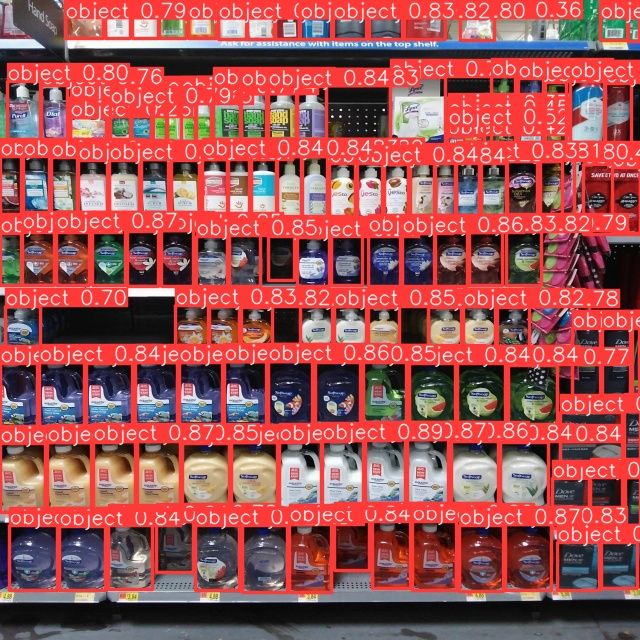

Displayed: runs/detect/predict/test_1177.jpg
----------------------------------------


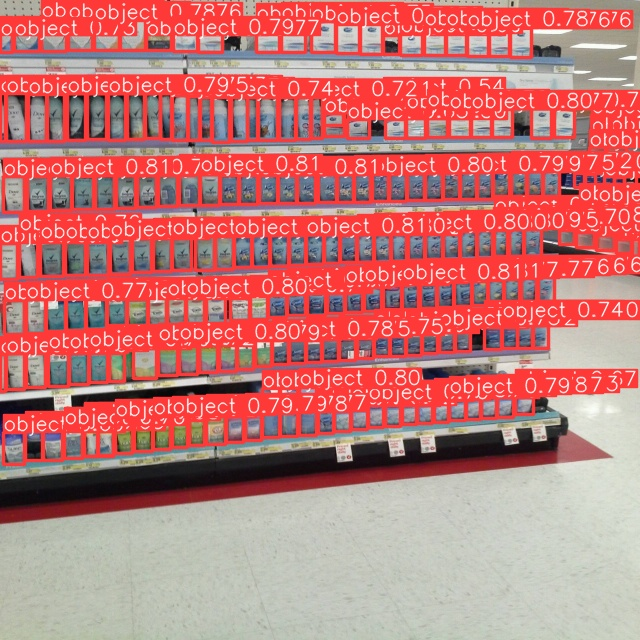

Displayed: runs/detect/predict/test_1475.jpg
----------------------------------------


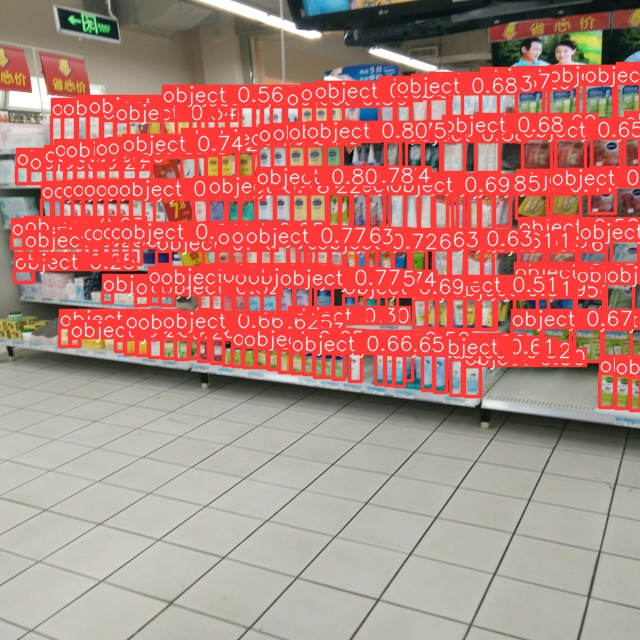

Displayed: runs/detect/predict/test_1548.jpg
----------------------------------------


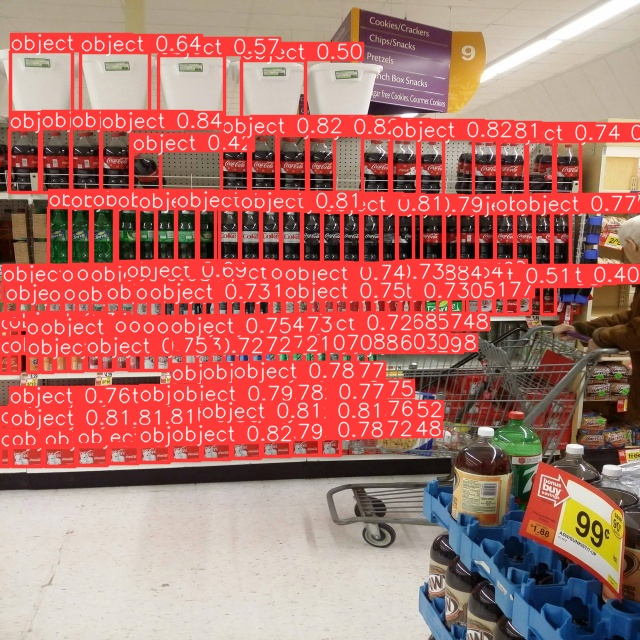

Displayed: runs/detect/predict/test_2065.jpg
----------------------------------------


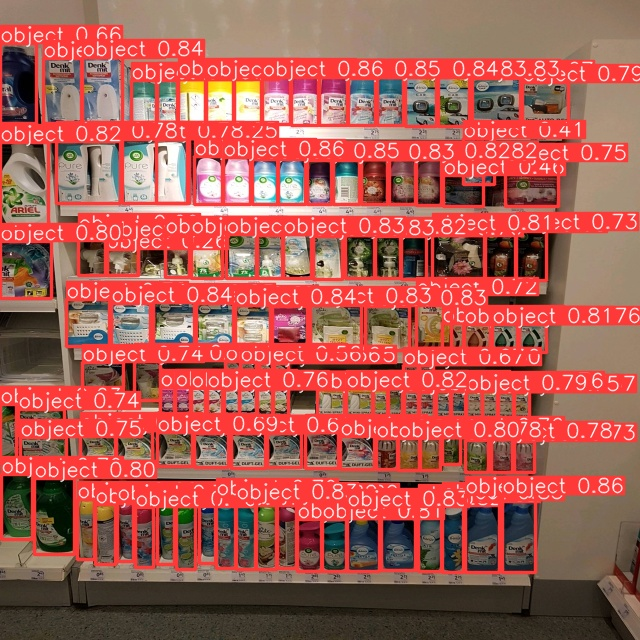

Displayed: runs/detect/predict/test_2490.jpg
----------------------------------------


In [34]:
import os
import glob
import random
from ultralytics import YOLO
from IPython.display import Image as IPyImage, display
import torch

WORK_ROOT = "/content/sku110"
IMG_DIR = os.path.join(WORK_ROOT, "images")
TEST_DIR = os.path.join(IMG_DIR, "test")


run_dirs = sorted(glob.glob("runs/detect/train*"))
if len(run_dirs) == 0:
    raise ValueError("❌ لم يتم العثور على تدريب داخل runs/detect/.")

last_run = run_dirs[-1]
best_weight_path = f"{last_run}/weights/best.pt"

print("✔ Using best weight file:", best_weight_path)

model = YOLO(best_weight_path)

device_eval = 0 if torch.cuda.is_available() else "cpu"


test_images = glob.glob(os.path.join(TEST_DIR, "*.jpg"))

if len(test_images) < 5:
    raise ValueError("❌ عدد صور test أقل من 5!")

random_images = random.sample(test_images, 5)

print("✔ Selected 5 random test images")




results = model.predict(
    source=random_images,
    imgsz=640,
    conf=0.25,
    device=device_eval,
    save=True
)



predict_dirs = sorted(glob.glob("runs/detect/predict*"))
last_pred_dir = predict_dirs[-1]

print("✔ Predictions saved in:", last_pred_dir)
print("\n===== Displaying the 5 predicted images =====\n")






predicted_imgs = sorted(glob.glob(os.path.join(last_pred_dir, "*.jpg")))



for img_path in predicted_imgs[:5]:
    display(IPyImage(filename=img_path))
    print("Displayed:", img_path)
    print("----------------------------------------")


In [35]:
from IPython.display import Image as IPyImage, display

pred_results = best_model.predict(
    source=os.path.join(IMG_DIR, "test"),
    imgsz=640,
    conf=0.25,
    device=yolo_device,
    save=True
)

print("✓ Predictions saved in:", pred_results[0].save_dir)

example_img_path = pred_results[0].plot_img
display(IPyImage(filename=example_img_path))
print("✓ Example detection shown.")




WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2899 /content/sku110/images/test/test_0.jpg: 640x640 140 objects, 27.2ms
image 2/2899 /content/sku110/images/test/test_1.jpg: 640x640 159 objects, 27.2ms
image 3/2899 /content/sku110/images/test/test_10.jpg: 640x640 145 objects, 27.2ms
image 4/2899 /content/sku110/images/test/test_100.jpg: 640x640 178 objects, 27.2ms
image 5/2899 /content/sku110/images/test/test_1000.jpg: 640x640 144 objects, 24.1ms
image 6/2899 /content/sku110/images/test/test

AttributeError: 'Results' object has no attribute 'plot_img'. See valid attributes below.

    A class for storing and manipulating inference results.

    Args:
        orig_img (numpy.ndarray): The original image as a numpy array.
        path (str): The path to the image file.
        names (dict): A dictionary of class names.
        boxes (torch.tensor, optional): A 2D tensor of bounding box coordinates for each detection.
        masks (torch.tensor, optional): A 3D tensor of detection masks, where each mask is a binary image.
        probs (torch.tensor, optional): A 1D tensor of probabilities of each class for classification task.
        keypoints (List[List[float]], optional): A list of detected keypoints for each object.

    Attributes:
        orig_img (numpy.ndarray): The original image as a numpy array.
        orig_shape (tuple): The original image shape in (height, width) format.
        boxes (Boxes, optional): A Boxes object containing the detection bounding boxes.
        masks (Masks, optional): A Masks object containing the detection masks.
        probs (Probs, optional): A Probs object containing probabilities of each class for classification task.
        keypoints (Keypoints, optional): A Keypoints object containing detected keypoints for each object.
        speed (dict): A dictionary of preprocess, inference, and postprocess speeds in milliseconds per image.
        names (dict): A dictionary of class names.
        path (str): The path to the image file.
        _keys (tuple): A tuple of attribute names for non-empty attributes.
    

In [36]:
import torch

def get_model_size(model):
    # احسب عدد البارامترات
    num_params = sum(p.numel() for p in model.parameters())

    # احسب الحجم بالبايت = عدد العناصر × 4 bytes (لأن float32)
    size_bytes = num_params * 4
    size_mb = size_bytes / (1024 * 1024)

    return num_params, size_mb

# مثال للاستخدام
num_params, size_mb = get_model_size(model.model)
print(f"Parameters: {num_params:,}")
print(f"Estimated model size: {size_mb:.2f} MB")


Parameters: 17,674,171
Estimated model size: 67.42 MB


In [37]:
import shutil
import glob
import os

# 1) البحث عن آخر مجلد تدريب
run_dirs = sorted(glob.glob("runs/detect/train*"))
if not run_dirs:
    raise ValueError("❌ No training runs found!")

last_run = run_dirs[-1]  # آخر تدريب

# 2) وسيف مكان ثابت لحفظ أفضل الموديلات
SAFE_DIR = "/content/saved_best_models"
os.makedirs(SAFE_DIR, exist_ok=True)

# 3) مسارات الملفات داخل مجلد التدريب
best_src = os.path.join(last_run, "weights/best.pt")
last_src = os.path.join(last_run, "weights/last.pt")
results_src = os.path.join(last_run, "results.csv")

# 4) نسخ الملفات إلى المجلد الجديد
if os.path.exists(best_src):
    shutil.copy(best_src, os.path.join(SAFE_DIR, "best.pt"))

if os.path.exists(last_src):
    shutil.copy(last_src, os.path.join(SAFE_DIR, "last.pt"))

if os.path.exists(results_src):
    shutil.copy(results_src, os.path.join(SAFE_DIR, "results.csv"))

print("✓ Saved best.pt and last.pt to:", SAFE_DIR)


✓ Saved best.pt and last.pt to: /content/saved_best_models


In [38]:
import shutil

folder_path = "/content/saved_best_models"   # مجلد الموديلات
zip_output = "/content/saved_models.zip"    # اسم ملف الضغط المطلوب

# إنشاء ملف ZIP
shutil.make_archive(zip_output.replace(".zip", ""), 'zip', folder_path)

print("✓ ZIP file created at:", zip_output)


✓ ZIP file created at: /content/saved_models.zip
